In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!touch "/content/drive/MyDrive/mbti_full_pull.csv"

In [ ]:
# create df
df = pd.read_csv("/content/drive/MyDrive/mbti_full_pull.csv")

In [ ]:
# drop the column that will not be used
df.drop("subreddit", inplace=True, axis=1)

In [ ]:
# remove missing values
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

author_flair_text    0
body                 0
dtype: int64

In [ ]:
# rename column that will be used
df = df.rename(columns={"author_flair_text" : "y" , "body" : "text"})
df.head

<bound method NDFrame.head of                  y                                               text
0             INTJ  Knowing you're in INTJ is a tool for you to us...
1             INTJ           You are truly an enlightened mastermind.
2        INFJ, 26F  You should :) it will help if you have a down ...
3             INTP  I watch a bit of everything (including hentai)...
4             INTJ  I don't know if I would count this as a pet pe...
...            ...                                                ...
1793956       INTP                                Remind me! 40 hours
1793957       INTJ  We are seeing the start of a process that is g...
1793958       INTJ  [NSFDL. I cry laughing at this every single ti...
1793959       INFJ                                         Ravenclaw!
1793960       INTP  I struggle massive with focusing, I would love...

[1793961 rows x 2 columns]>

In [ ]:
# Cleaning for y column (converting to uppercase and remove noise)
df["y"] = df["y"].str.upper()
df["y"].value_counts()

INTP                            366505
INTJ                            323717
ENFP                             88438
ENTP                             80836
INFJ                             71676
                                 ...  
AN ENTJ                              1
INFJ |19 | F                         1
INFJ | SURELY | ��                   1
ENFP: IT'S GETTING COLD OUT.         1
35M INTP                             1
Name: y, Length: 8337, dtype: int64

In [ ]:
# clear out noise
import re

pattern = "[IE][SN][FT][PJ]"

df["y"] = df["y"].apply(lambda x: re.findall("[IE][SN][FT][PJ]", x)).apply(lambda x: x[0] if x else None)

df["y"].value_counts()

INTP    474174
INTJ    365450
ENTP    223000
INFJ    206966
INFP    180164
ENFP     98171
ISTP     64965
ESTP     53258
ENTJ     51067
ENFJ     21254
ISTJ     18395
ISFP     11430
ISFJ      7911
ESFP      7730
ESTJ      7232
ESFJ      2794
Name: y, dtype: int64

In [ ]:
df = df.groupby("y").head(150)

In [ ]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)   
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
df["text_clean"] = df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df.head()

,y,text,text_clean
0,INTJ,Knowing you're in INTJ is a tool for you to us...,knowing youre intj tool use interaction people...
1,INTJ,You are truly an enlightened mastermind.,truly enlightened mastermind
2,INFJ,You should :) it will help if you have a down ...,help moment hobby keep mind busy dont like loo...
3,INTP,I watch a bit of everything (including hentai)...,watch bit everything including hentai tend enj...
4,INTJ,I don't know if I would count this as a pet pe...,dont know would count pet peeze something time...


In [ ]:
df["text_clean"] = df["text_clean"].str.slice(stop=512)

In [ ]:
batch_1 = df

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenized = batch_1["text_clean"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(2400, 186)

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2400, 186)

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TP U detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
use_gpu = True
# Create model
with tpu_strategy.scope():
    model = model
if not use_gpu:
    model = model
    
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Tensorflow version 2.9.2
Running on TPU  ['10.120.183.42:8470']


In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
labels = batch_1["y"]

In [ ]:
from sklearn.metrics import classification_report
classifier = LogisticRegression()
train_data, test_data, train_cats, test_cats = train_test_split(features,labels)
classifier.fit(train_data, train_cats)
print("Accuracy: ", classifier.score(test_data, test_cats))
preds = classifier.predict(test_data)
print(classification_report(test_cats, preds))

Accuracy:  0.10833333333333334
              precision    recall  f1-score   support

        ENFJ       0.07      0.04      0.06        45
        ENFP       0.11      0.09      0.10        46
        ENTJ       0.09      0.18      0.12        22
        ENTP       0.03      0.03      0.03        36
        ESFJ       0.08      0.11      0.09        37
        ESFP       0.09      0.11      0.10        37
        ESTJ       0.27      0.16      0.20        44
        ESTP       0.23      0.24      0.24        33
        INFJ       0.10      0.14      0.12        35
        INFP       0.07      0.05      0.06        37
        INTJ       0.00      0.00      0.00        31
        INTP       0.09      0.11      0.10        37
        ISFJ       0.06      0.05      0.06        38
        ISFP       0.10      0.07      0.08        43
        ISTJ       0.24      0.14      0.18        43
        ISTP       0.21      0.25      0.23        36

    accuracy                           0.11      

In [ ]:
predicted_prob = classifier.predict_proba(test_data)
y_test_array = pd.get_dummies(test_cats.values, drop_first=False).values

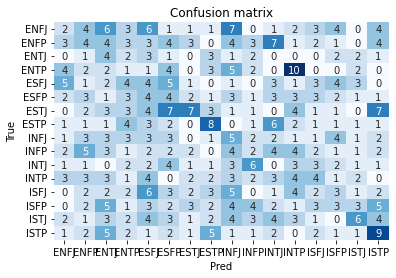

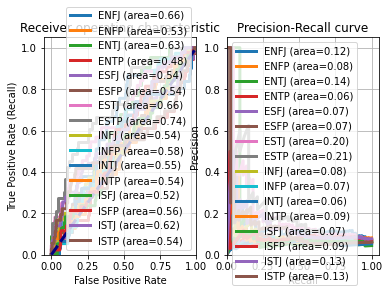

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import seaborn as sns
classes = np.unique(test_cats)

## Plot confusion matrix
cm = metrics.confusion_matrix(test_cats, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
